# Experiment Comparison: Transformer vs xLSTM

This notebook loads the consolidated results from `artifacts/summary/all_runs.csv` and produces a few concise comparisons to answer the research questions:

1. Predictive performance: Transformer vs xLSTM (accuracy, macro-F1)
2. Impact of sequence length and dataset variant
3. Efficiency: parameters, runtime, memory

> **Note:** Run `python -m sizerec.collect_runs` first to create the CSV.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

summary_path = Path('artifacts/summary/all_runs.csv')
if not summary_path.exists():
    raise FileNotFoundError("Could not find artifacts/summary/all_runs.csv. Run the collector first: python -m sizerec.collect_runs")

df = pd.read_csv(summary_path)
print(f"Loaded {len(df)} runs from {summary_path}")
df.head()

Loaded 4 runs from artifacts/summary/all_runs.csv


,run_dir,experiment_name,model_type,max_len,csv_dir,seed,params_millions,epoch_time_sec_mean,peak_cuda_mb,peak_cpu_mb,fit_time_sec,val_accuracy,val_macro_f1,test_accuracy,test_macro_f1
0,/Users/amandamagzal/size-fit-rec/artifacts/run...,tf_len16_small_s1,transformer,16,data,1,3.182,4.305221,NaN,NaN,40.506329,0.356354,0.312033,0.377551,0.321803
1,/Users/amandamagzal/size-fit-rec/artifacts/run...,tf_len32_small_s1,transformer,32,data,1,3.186,4.487936,NaN,NaN,41.507525,0.331492,0.275460,0.329082,0.272466
2,/Users/amandamagzal/size-fit-rec/artifacts/run...,xlstm_len16_small_s1,xlstm,16,data,1,2.128,1.512578,NaN,NaN,26.769867,0.378453,0.289630,0.387755,0.319257
3,/Users/amandamagzal/size-fit-rec/artifacts/run...,xlstm_len32_small_s1,xlstm,32,data,1,2.132,1.549404,NaN,NaN,28.866146,0.450276,0.364950,0.367347,0.287307


## 1) Overall predictive performance
We aggregate across seeds (and datasets, if multiple) to compare **macro-F1** and **accuracy** by model.

In [2]:
def mean_std_str(x):
    return f"{x.mean():.3f} ± {x.std():.3f}" if len(x) > 1 else f"{x.mean():.3f}"

agg = df.groupby('model_type').agg(
    test_macro_f1_mean=('test_macro_f1', 'mean'),
    test_macro_f1_std=('test_macro_f1', 'std'),
    test_accuracy_mean=('test_accuracy', 'mean'),
    test_accuracy_std=('test_accuracy', 'std'),
    runs=('run_dir', 'count')
).reset_index()
agg['macroF1 (mean±std)'] = agg['test_macro_f1_mean'].round(3).astype(str) + ' ± ' + agg['test_macro_f1_std'].fillna(0).round(3).astype(str)
agg['acc (mean±std)'] = agg['test_accuracy_mean'].round(3).astype(str) + ' ± ' + agg['test_accuracy_std'].fillna(0).round(3).astype(str)
cols = ['model_type','runs','macroF1 (mean±std)','acc (mean±std)']
agg[cols]

,model_type,runs,macroF1 (mean±std),acc (mean±std)
0,transformer,2,0.297 ± 0.035,0.353 ± 0.034
1,xlstm,2,0.303 ± 0.023,0.378 ± 0.014


### Bar charts (macro-F1 and accuracy)

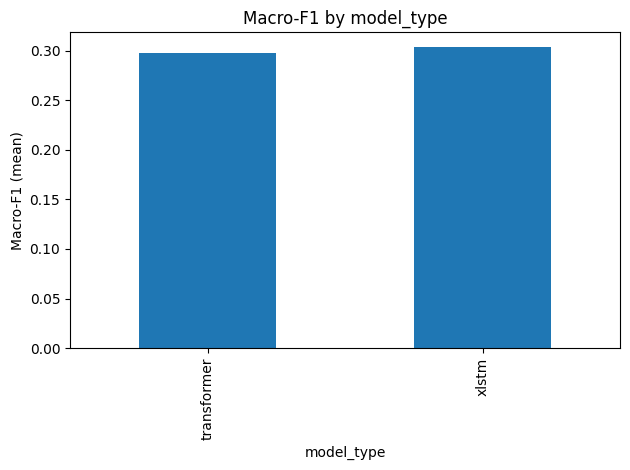

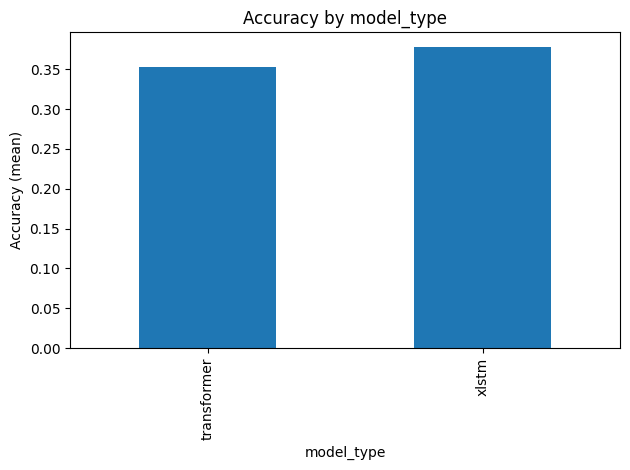

In [3]:
plt.figure()
bar = df.groupby('model_type')['test_macro_f1'].mean().sort_values()
bar.plot(kind='bar')
plt.ylabel('Macro-F1 (mean)')
plt.title('Macro-F1 by model_type')
plt.tight_layout()
plt.show()

plt.figure()
bar = df.groupby('model_type')['test_accuracy'].mean().sort_values()
bar.plot(kind='bar')
plt.ylabel('Accuracy (mean)')
plt.title('Accuracy by model_type')
plt.tight_layout()
plt.show()

## 2) Impact of sequence length and dataset
We visualize **macro-F1 vs `max_len`** for each model type; if multiple datasets (csv_dir) exist, we facet by dataset.

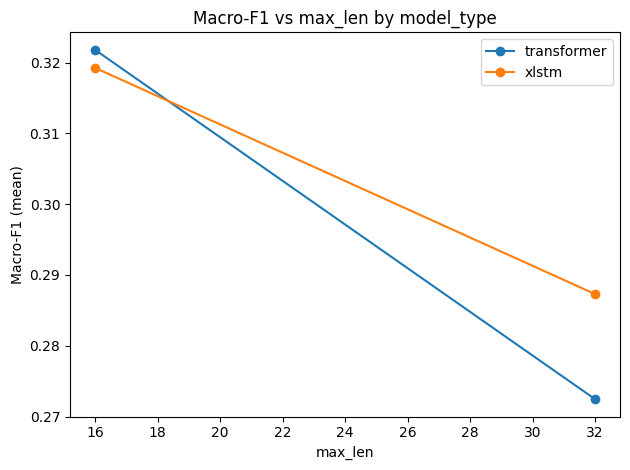

In [4]:
def line_plot_macroF1_vs_len(sub):
    pivot = sub.groupby(['model_type','max_len'])['test_macro_f1'].mean().reset_index()
    lens = sorted(pivot['max_len'].dropna().unique())
    models = sorted(pivot['model_type'].dropna().unique())
    plt.figure()
    for m in models:
        y = [pivot[(pivot['model_type']==m) & (pivot['max_len']==L)]['test_macro_f1'].mean() if L in pivot['max_len'].values else np.nan for L in lens]
        plt.plot(lens, y, marker='o', label=m)
    plt.xlabel('max_len')
    plt.ylabel('Macro-F1 (mean)')
    plt.title('Macro-F1 vs max_len by model_type')
    plt.legend()
    plt.tight_layout()
    plt.show()

if 'csv_dir' in df.columns and df['csv_dir'].nunique() > 1:
    for ds, sub in df.groupby('csv_dir'):
        print(f"Dataset: {ds}")
        line_plot_macroF1_vs_len(sub)
else:
    line_plot_macroF1_vs_len(df)

## 3) Efficiency: parameters, time, memory
Scatter/line plots to compare parameter counts, epoch time, and peak GPU memory (if logged).

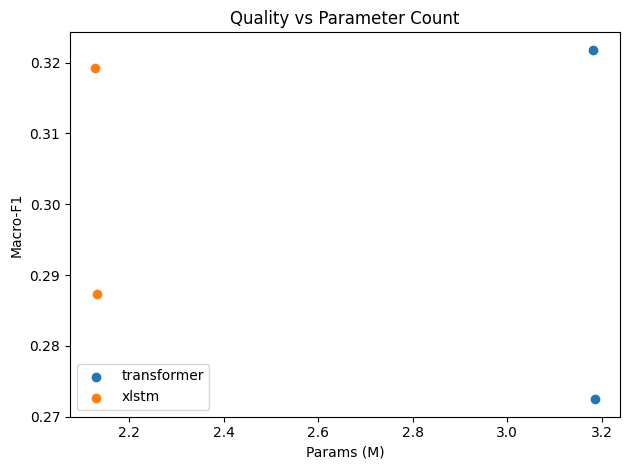

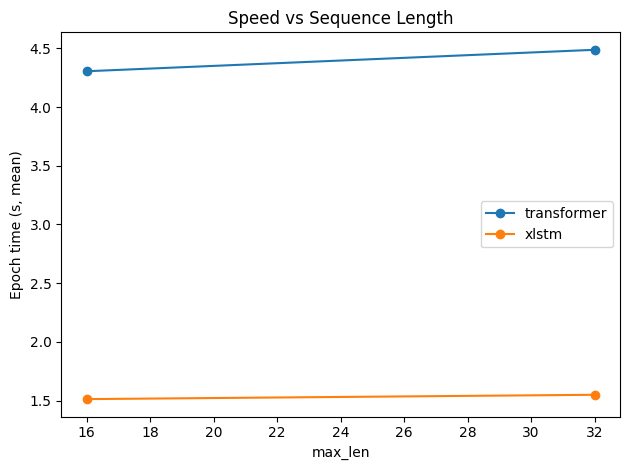

peak_cuda_mb not available in CSV; skipping memory plot.


In [5]:
# Params vs Macro-F1 scatter
if 'params_millions' in df.columns and not df['params_millions'].isna().all():
    plt.figure()
    for m, sub in df.groupby('model_type'):
        plt.scatter(sub['params_millions'], sub['test_macro_f1'], label=m)
    plt.xlabel('Params (M)')
    plt.ylabel('Macro-F1')
    plt.title('Quality vs Parameter Count')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('params_millions not available in CSV; skipping scatter.')

# Epoch time vs max_len line
if 'epoch_time_sec_mean' in df.columns and not df['epoch_time_sec_mean'].isna().all():
    pivot = df.groupby(['model_type','max_len'])['epoch_time_sec_mean'].mean().reset_index()
    lens = sorted(pivot['max_len'].dropna().unique())
    models = sorted(pivot['model_type'].dropna().unique())
    plt.figure()
    for m in models:
        y = [pivot[(pivot['model_type']==m) & (pivot['max_len']==L)]['epoch_time_sec_mean'].mean() if L in pivot['max_len'].values else np.nan for L in lens]
        plt.plot(lens, y, marker='o', label=m)
    plt.xlabel('max_len')
    plt.ylabel('Epoch time (s, mean)')
    plt.title('Speed vs Sequence Length')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('epoch_time_sec_mean not available in CSV; skipping speed plot.')

# Peak CUDA memory (if present)
if 'peak_cuda_mb' in df.columns and not df['peak_cuda_mb'].isna().all():
    mem = df.groupby('model_type')['peak_cuda_mb'].mean().dropna()
    if not mem.empty:
        plt.figure()
        mem.plot(kind='bar')
        plt.ylabel('Peak CUDA memory (MB)')
        plt.title('Peak Memory by Model')
        plt.tight_layout()
        plt.show()
    else:
        print('No CUDA memory stats recorded; skipping memory plot.')
else:
    print('peak_cuda_mb not available in CSV; skipping memory plot.')

## 4) Paired deltas (xLSTM − Transformer)
Compute per-setup differences to see which model wins when holding setup constant. We match runs by `(csv_dir, max_len, seed)`.

In [6]:
# Filter to only rows that have both models for the same (csv_dir, max_len, seed)
keys = ['csv_dir','max_len','seed'] if 'csv_dir' in df.columns else ['max_len','seed']
pivot = df.pivot_table(index=keys, columns='model_type', values='test_macro_f1')
pivot = pivot.dropna()  # keep only matched pairs
if not pivot.empty and all(m in pivot.columns for m in ['transformer','xlstm']):
    pivot['delta_macroF1'] = pivot['xlstm'] - pivot['transformer']
    print('Paired deltas (xLSTM − Transformer):')
    display(pivot[['delta_macroF1']].describe().T)
else:
    print('Not enough matched pairs to compute deltas.')

Paired deltas (xLSTM − Transformer):


,count,mean,std,min,25%,50%,75%,max
model_type,,,,,,,,
delta_macroF1,2.0,0.006148,0.012294,-0.002546,0.001801,0.006148,0.010494,0.014841


## 5) Save a compact table
One tidy table with the most useful columns for reporting.

In [7]:
keep_cols = [
    'experiment_name','model_type','csv_dir','max_len','seed',
    'params_millions','epoch_time_sec_mean','peak_cuda_mb',
    'test_macro_f1','test_accuracy','run_dir'
]
export = df[[c for c in keep_cols if c in df.columns]].copy()
out_path = Path('artifacts/summary/for_report.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
export.to_csv(out_path, index=False)
print(f'Saved: {out_path}  ({len(export)} rows)')

Saved: artifacts/summary/for_report.csv  (4 rows)
